In [1]:
#Heavily modified from 
#http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#contact: Mark Cheung, cheung@lmsal.com

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pickle
import sys
if sys.version_info <= (3,5):
    import ConfigParser
else:
    import configparser as ConfigParser
import sting


Using TensorFlow backend.


In [2]:
# Read local config file
config = ConfigParser.RawConfigParser()
config.read('myconfig.cfg')
DIR = config.get('LSTMCFG','DIR')
FILENAME = config.get('LSTMCFG','FILENAME')
batch_size = int(config.get('LSTMCFG', 'BATCH_SIZE'))
#OUTPUT = config.get('LSTMCFG','OUTPUT')
#TIMES = map(int, config.get('LSTMCFG','TIMES').split(','))
#nb_epoch = int(config.get('LSTMCFG', 'NB_EPOCH'))

In [3]:
#Load USGS data
OBSERVATORIES = ('BOU', 'BRW', 'BSL', 'CMO', 'DED', 'FRD',
    'FRN', 'GUA', 'HON', 'NEW', 'SHU', 'SIT', 'SJG', 'TUC')
CHANNELS = ('X', 'Y', 'Z') 

# Number of magnetic channels/components per observatory
nchannels = len(CHANNELS)

DIR = "/data/st/geomag_2015_2016_xyzf/"
FILENAME = 'X_2015_minutes.pkl'
timeseries=np.array(pickle.load(open(DIR + FILENAME,'rb'),  encoding="latin1"))
timeseries2=np.zeros([len(OBSERVATORIES)*nchannels,timeseries.shape[1]],dtype='float')
for o in range(timeseries.shape[0]):
    timeseries2[o*3+0,:] = timeseries[o,:]
FILENAME = 'Y_2015_minutes.pkl'
timeseries=np.array(pickle.load(open(DIR + FILENAME,'rb'),  encoding="latin1"))
for o in range(timeseries.shape[0]):
    timeseries2[o*3+1,:] = timeseries[o,:]
FILENAME = 'Z_2015_minutes.pkl'
timeseries=np.array(pickle.load(open(DIR + FILENAME,'rb'),  encoding="latin1"))
for o in range(timeseries.shape[0]):
    timeseries2[o*3+2,:] = timeseries[o,:]
timeseries = timeseries2
    
print("timeseries.shape=",timeseries.shape)

raw_values = timeseries[:,:]
nchannels = raw_values.shape[0]

# Subsample / average in time
# Averaging window for subsampling in time
window = 60 
sampled_values, time = sting.raw_to_sampled(raw_values,window)

# Now we create rows that comprise of timeseries data with different lags, all concatenated together.
lags = np.array([0],dtype='int')

#print("sampled_values.shape",sampled_values.shape)
#print(sampled_values[0,:])

timeseries.shape= (42, 525600)
time.shape (8760,)
nchannels= 42


In [4]:
%matplotlib inline
for i in range(nchannels):
    if np.isnan(np.nanmean(timeseries[i,:])):
        print(i,np.nanmean(timeseries[i,:]))

In [5]:
# Scale data
train_scaled, test_scaled, scalers = sting.sampled_to_scaled(sampled_values, time, nchannels, lags, batch_size)
print(train_scaled.shape, test_scaled.shape)
print('len(scalers)',len(scalers))
#Save scaling functions
pickle.dump(scalers, open("scalers_window{0:03d}_lags{1:03d}.pkl".format(window,np.max(lags)),"wb"))

supervised_values.shape (8760, 1, 42)
supervised_values.shape (8760, 1, 42)
6912
train.shape (6912, 1, 42)
test.shape (1848, 1, 42)
(6912, 42) (1848, 42)
len(scalers) 42


/home/mcheung/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mcheung/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mcheung/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

0 0
-98463.771 67425.552


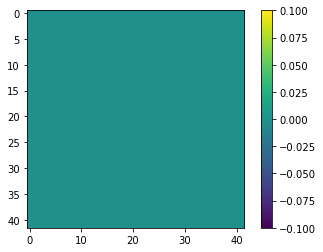

In [6]:
from scipy.misc import imresize
#%matplotlib inline
#import matplotlib.pyplot as plt
#from scipy import interpolate
#time = np.arange(np.floor(raw_values.shape[1]/window),dtype='int')*window
#print(time)
#print(raw_values.shape)
#i= 0
#y = raw_values[i,time].ravel()
#good = np.isfinite(y)
#f = interpolate.interp1d(time[good].astype(float), y[good],fill_value='extrapolate')
#sampled_values[i,:] = f(time.astype(float))
#sampled_values, time = sting.raw_to_sampled(raw_values,window)
#plt.plot(raw_values[i,:])

def rebin(a, *args):
    import numpy as np
    '''rebin ndarray data into a smaller ndarray of the same rank whose dimensions
    are factors of the original dimensions. eg. An array with 6 columns and 4 rows
    can be reduced to have 6,3,2 or 1 columns and 4,2 or 1 rows.
    example usages:
    >>> a=rand(6,4); b=rebin(a,3,2)
    >>> a=rand(6); b=rebin(a,2)
    '''
    shape = a.shape
    lenShape = len(shape)
    factor = np.asarray(shape)/np.asarray(args)
    evList = ['a.reshape('] + \
             ['args[%d],factor[%d],'%(i,i) for i in range(lenShape)] + \
             [')'] + ['.sum(%d)'%(i+1) for i in range(lenShape)] + \
             ['/factor[%d]'%i for i in range(lenShape)]
    print(''.join(evList))
    return eval(''.join(evList))

img = imresize(np.isfinite(raw_values).astype(int),(timeseries.shape[0], timeseries.shape[0]),interp='nearest')
print(img.max(),img.min())
pyplot.imshow(img)

print(raw_values.min(),raw_values.max())
#test = rebin(np.isfinite(timeseries),timeseries.shape[0],timeseries.shape[0])#)
pyplot.colorbar()
pyplot.show()

In [7]:
# repeat experiment
repeats = 1
error_scores = list()
# for r in range(repeats):
# fit the model
lstm_model, lstm_model_pred = sting.fit_lstm_deep(train_scaled, batch_size, 201, nchannels*2)
# forecast the entire training dataset to build up state for forecasting
# walk-forward validation on the test data 

(6784, 42) (6784, 42)
(6784, 1, 42) (6784, 42)
Epoch 1/1
6784/6784 [==============================] - 1s - loss: 6.5726     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 6.1319     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 6.0018     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.8399     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.8398     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.8164     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.7596     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.5936     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.6479     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.4110     
Epoch 1/1
6784/6784 [==============================] - 0s - loss: 5.4691     


In [8]:
#Save trained model. The difference between lstm_model and lstm_model_pred is that the latter has batch_size=1
lstm_model.save_weights('lstm_model_window{0:03d}_lags{1:03d}.h5'.format(window,np.max(lags)))
lstm_model_pred.load_weights('lstm_model_window{0:03d}_lags{1:03d}.h5'.format(window,np.max(lags)))
model_json = lstm_model_pred.to_json()
with open("model_window{0:03d}_lags{1:03d}.json".format(window,np.max(lags)), "w") as json_file:
    json_file.write(model_json)

In [9]:
predictions = np.zeros([test_scaled.shape[0],test_scaled.shape[1]])
for r in range(repeats):    
    for i in range(len(test_scaled)-1):
        # make one-step forecast
        X, y = test_scaled[i, :], test_scaled[i+1,:]
        #X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = sting.forecast_lstm(lstm_model_pred, 1, X)
        yhat = yhat[0,:]
        # store forecast
        predictions[i,:] = yhat
        # report performance
        #rmse = sqrt(mean_squared_error(raw_values[len(time)-wall:], predictions))
        #rmse_baseine = sqrt(mean_squared_error(raw_values[len(time)-wall:], shift(predictions,-1)))    
        #print('%d) Test RMSE: %.3f' % (r+1, rmse))
        #print('%d) Test RMSE: %.3f' % (r+1, rmse_baseline))
        #error_scores.append(rmse)

In [10]:
print(test_scaled.shape,predictions.shape)

(1848, 42) (1848, 42)


In [11]:
nchannels

42

In [12]:
inverted_predictions = predictions.reshape([predictions.shape[0],lags.shape[0],nchannels])
inverted_test = test_scaled.reshape([predictions.shape[0],lags.shape[0],nchannels])
#for c in range(len(scalers)):
#    sc = scalers[c]
#    inverted_predictions[:,c] = sc.inverse_transform(predictions[:,c].ravel())
#    inverted_test[:,c] = sc.inverse_transform(test_scaled[:,c].ravel())

#inverted_predictions = inverted_predictions.reshape([predictions.shape[0],lags.shape[0],nchannels])
print("predictions.shape",inverted_predictions.shape)
#inverted_test = inverted_test.reshape([predictions.shape[0],lags.shape[0],nchannels])
print("inverted_test.shape",inverted_test.shape)

for c in range(len(scalers)):
    sc = scalers[c]
    #inverted_predictions[:,:,c] = 
    sc.inverse_transform(inverted_predictions[:,:,c])
    #inverted_test[:,:,c] = 
    sc.inverse_transform(inverted_test[:,:,c])

#print(inverted_predictions[:,3,0])
#print(inverted_test[:,3,0])

predictions.shape (1848, 1, 42)
inverted_test.shape (1848, 1, 42)


In [13]:
%matplotlib inline

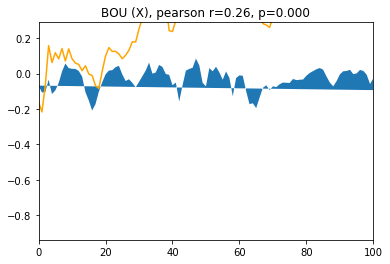

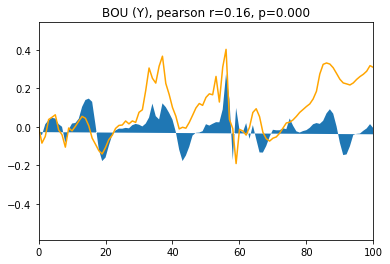

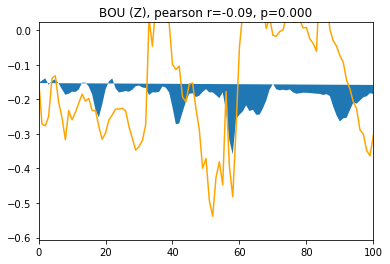

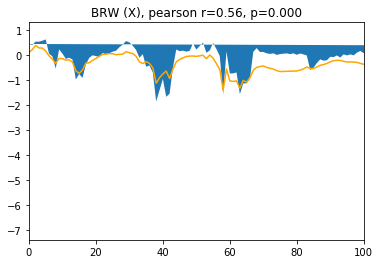

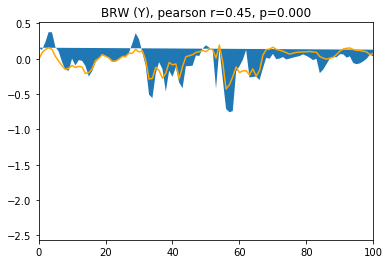

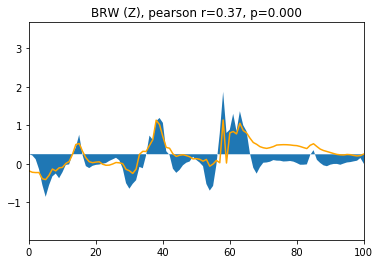

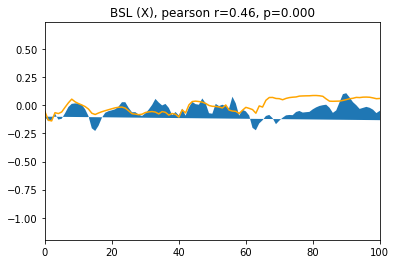

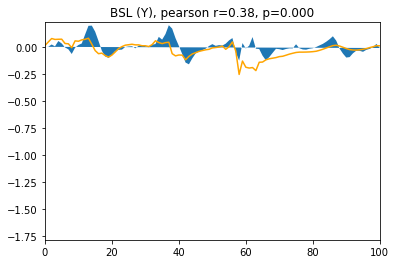

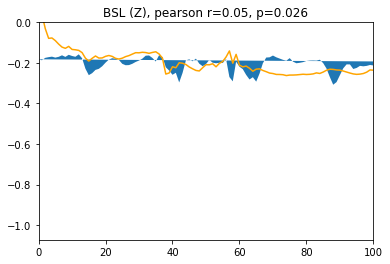

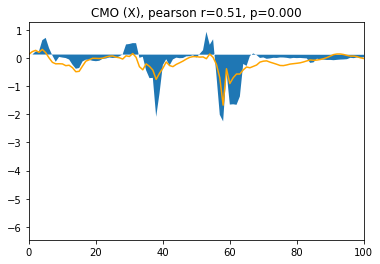

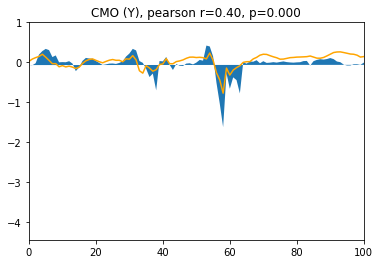

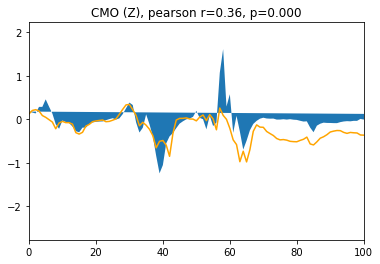

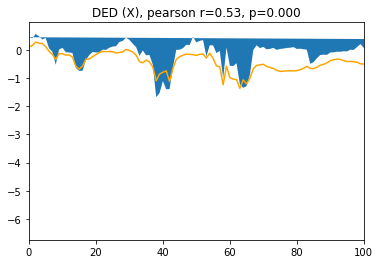

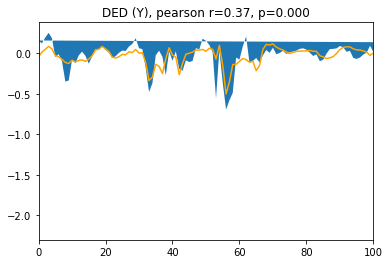

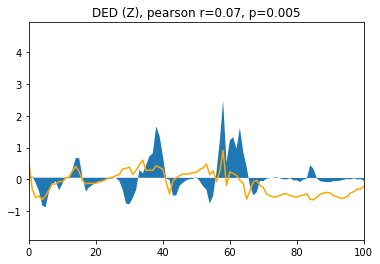

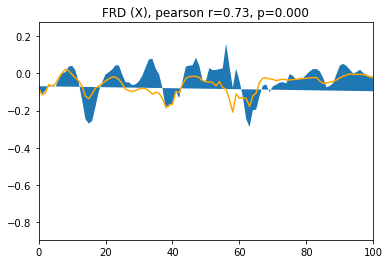

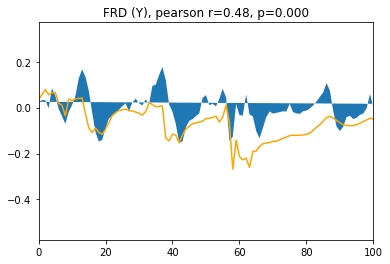

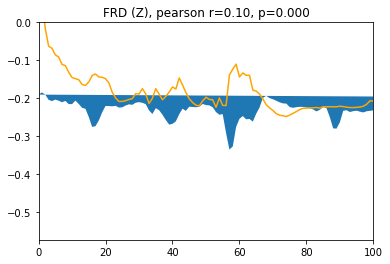

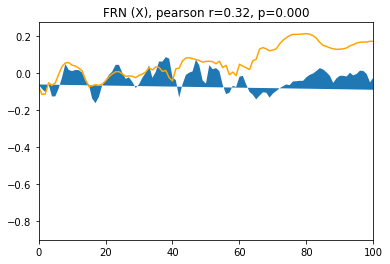

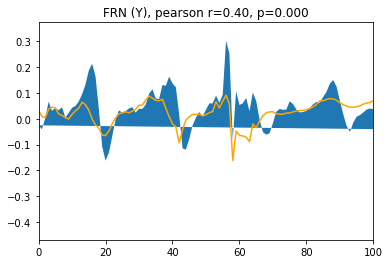

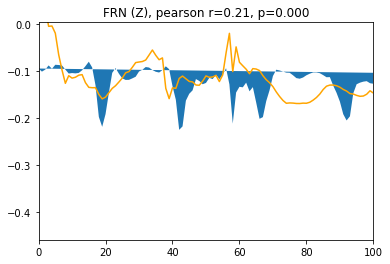

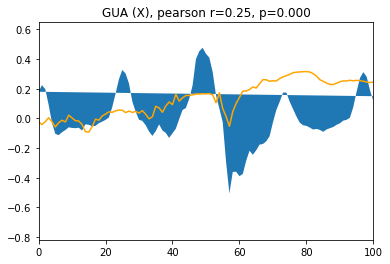

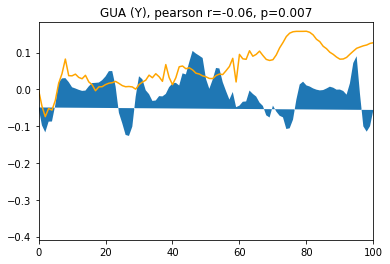

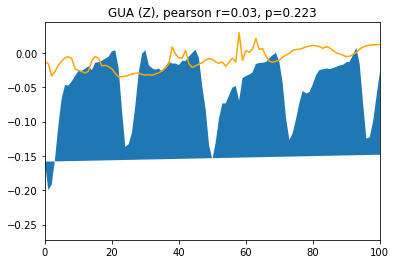

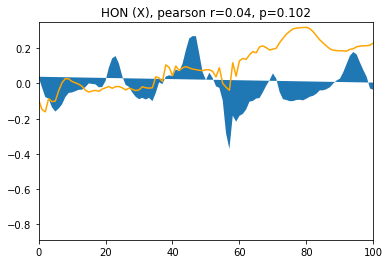

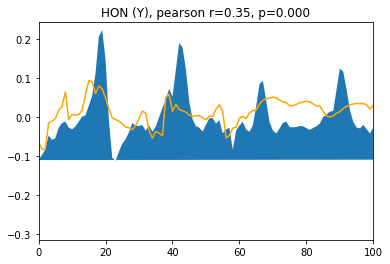

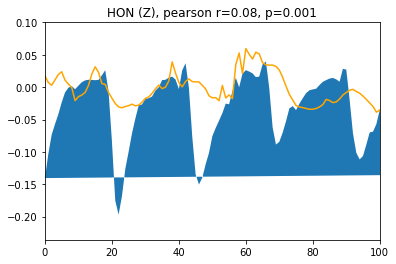

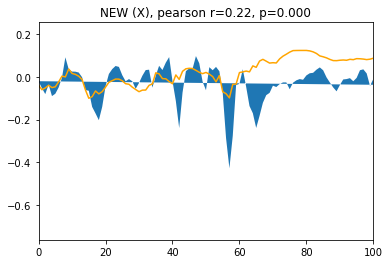

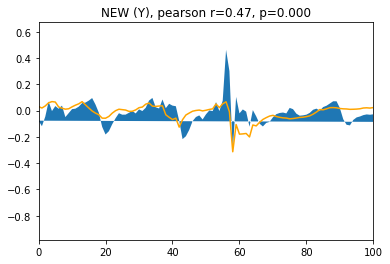

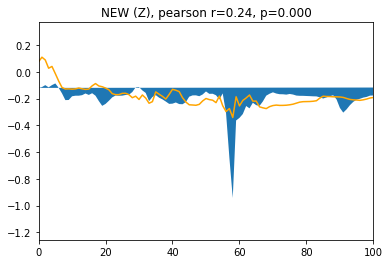

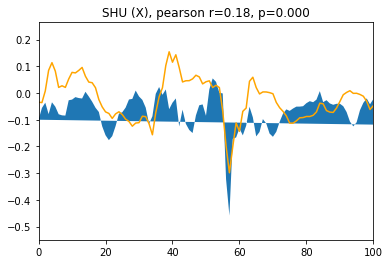

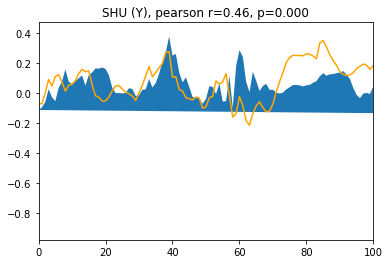

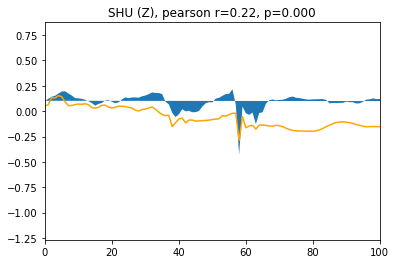

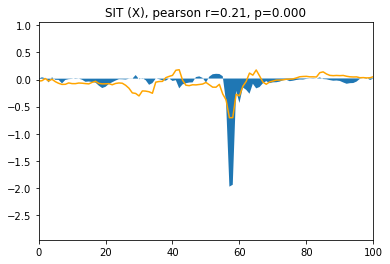

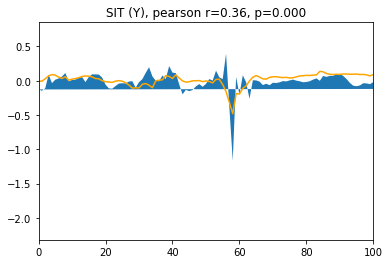

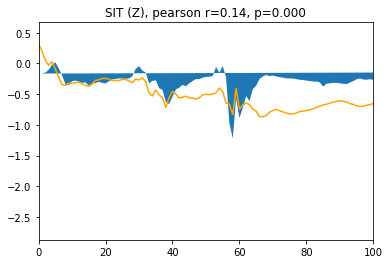

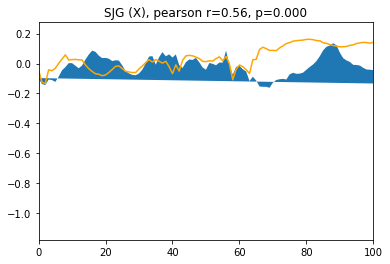

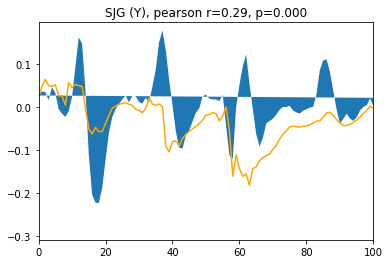

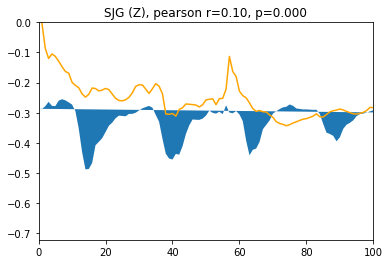

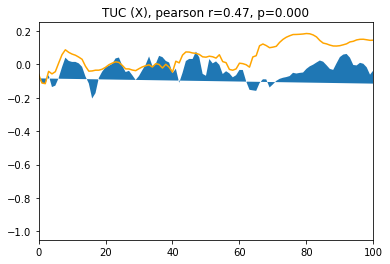

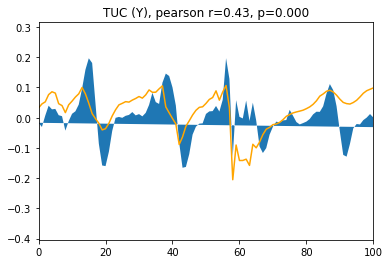

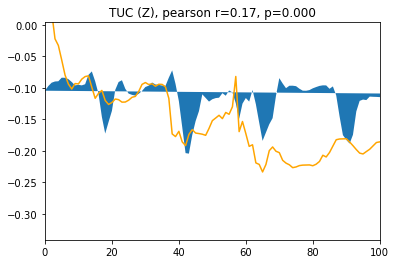

In [14]:
from scipy.stats import pearsonr

for c in range(nchannels):
    pyplot.figure(c)
    obs = int(np.floor(c/len(CHANNELS)))
    comp = c % len(CHANNELS)
    x = inverted_test[:,len(lags)-1,c]
    y = inverted_predictions[:,len(lags)-1,c]
    pyplot.fill(x)
    pyplot.plot(y,color='orange')
    #pyplot.ylim(predictions[:,len(lags)-1,c].min(),predictions[:,len(lags)-1,c].max())
    pyplot.xlim(0,100)
    pyplot.ylim(x.min(),x.max())
    corr = pearsonr(x,y)
    pyplot.title("{0} ({1}), pearson r={2:.2f}, p={3:.3f}".format(OBSERVATORIES[obs],CHANNELS[comp],corr[0],corr[1]))
    pyplot.show()


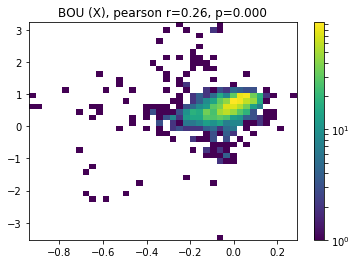

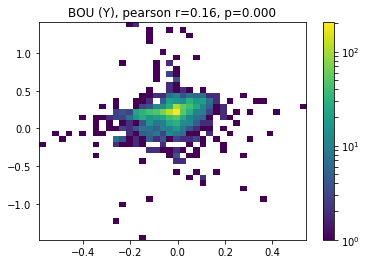

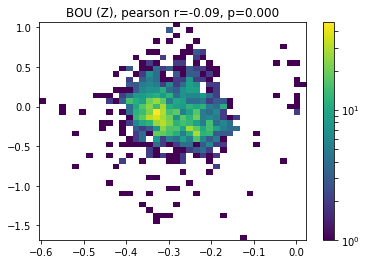

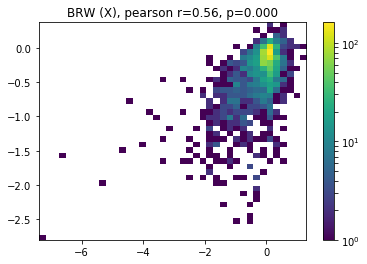

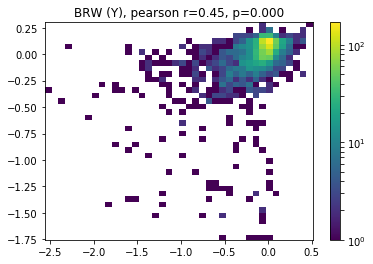

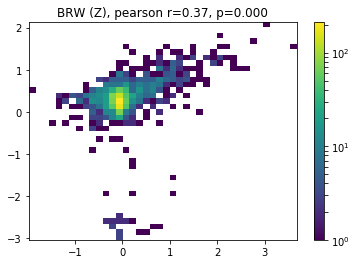

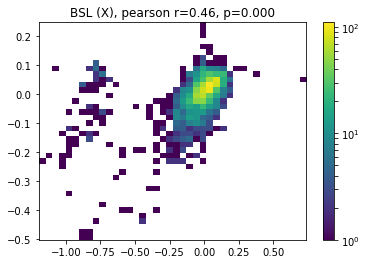

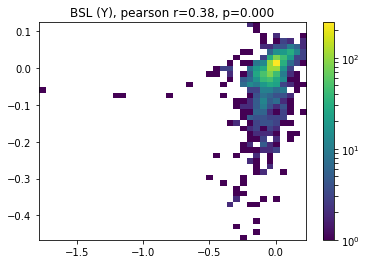

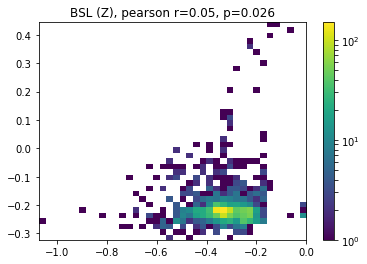

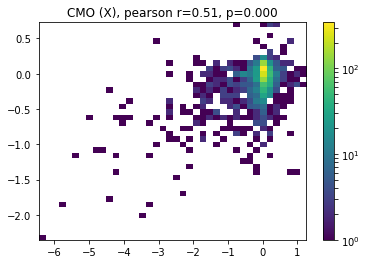

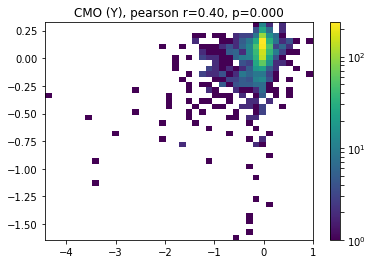

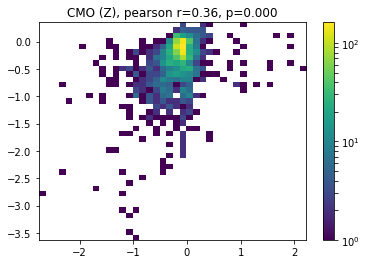

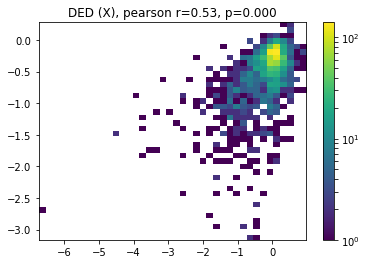

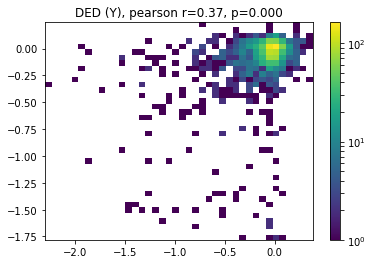

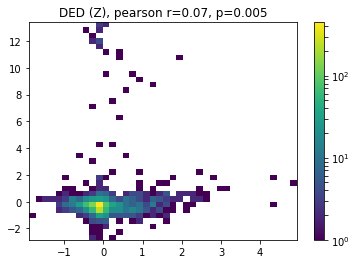

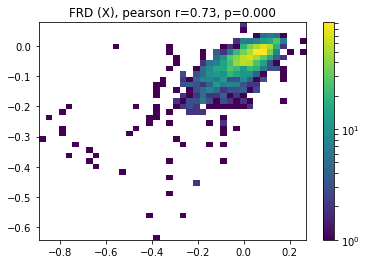

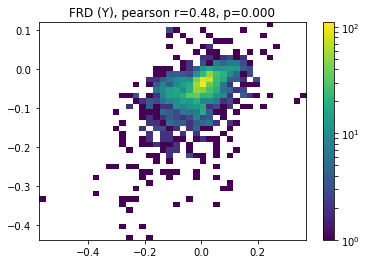

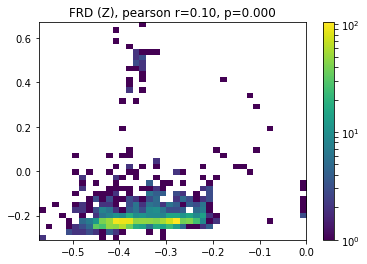

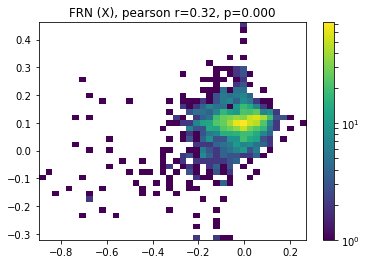

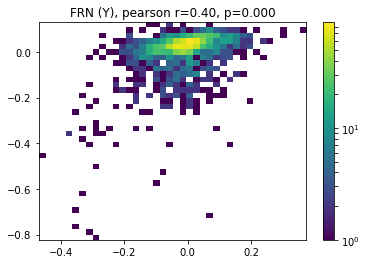

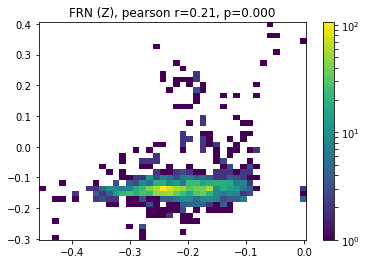

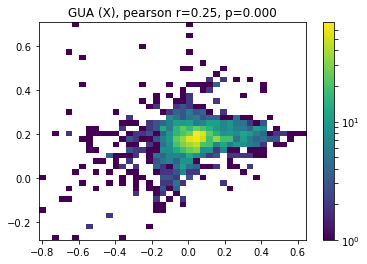

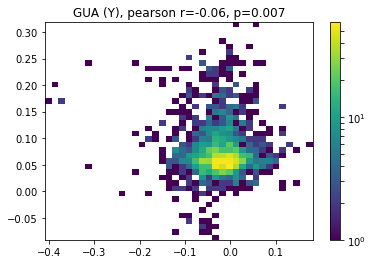

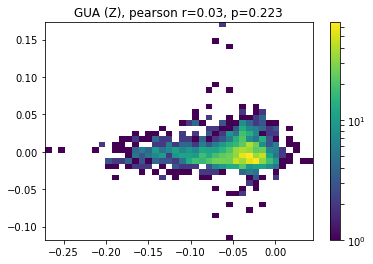

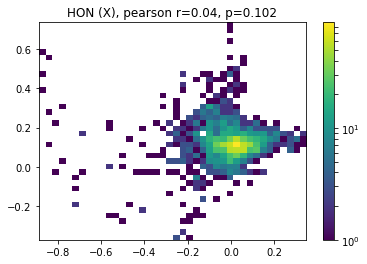

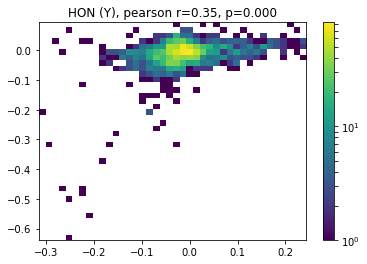

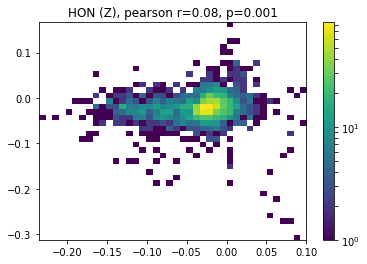

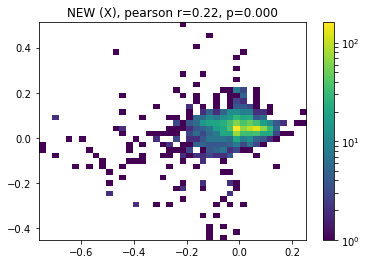

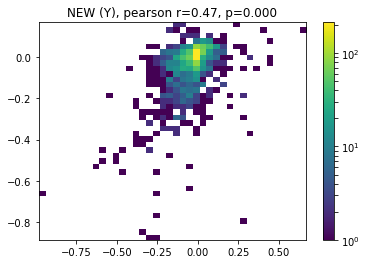

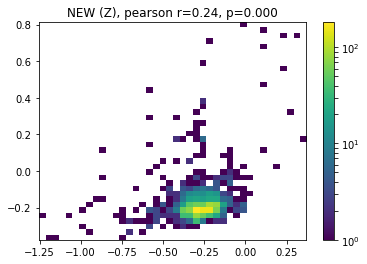

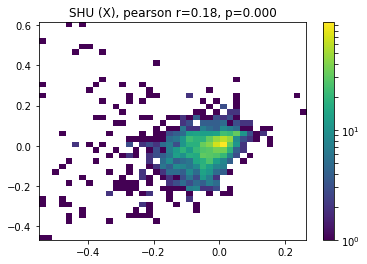

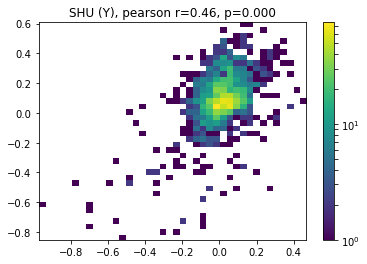

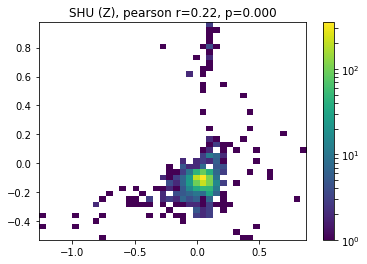

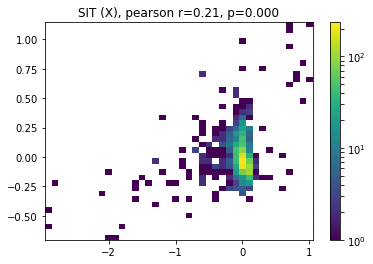

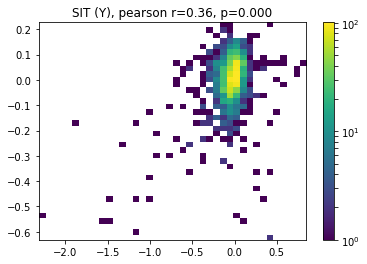

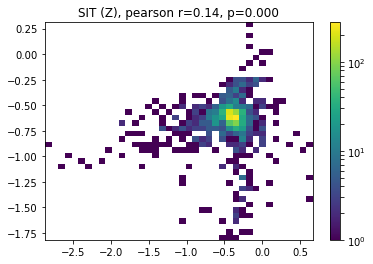

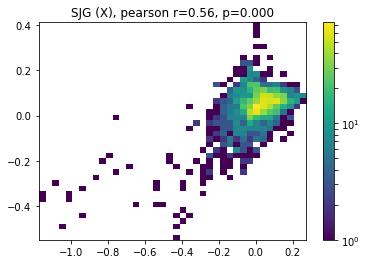

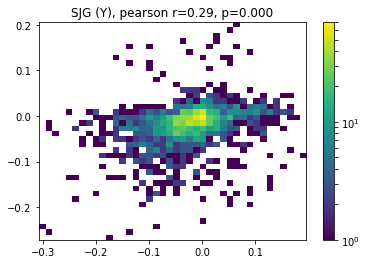

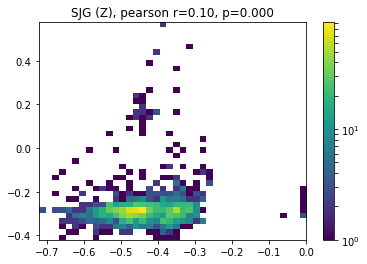

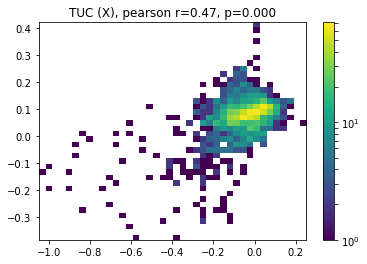

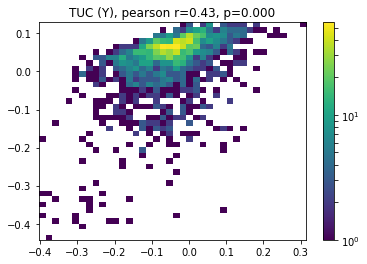

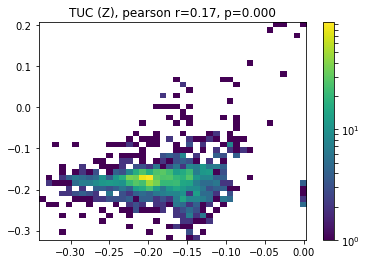

In [15]:
from matplotlib.colors import LogNorm

#metric = np.array([2,inverted_test.shape[2]])
f = open("model_window{0:03d}_lags{1:03d}.metrics".format(window,np.max(lags)), "w")

for c in range(inverted_test.shape[2]):
    pyplot.figure(c)
    obs = int(np.floor(c/len(CHANNELS)))
    comp = c % len(CHANNELS)

    x = inverted_test[:,len(lags)-1,c]
    y = inverted_predictions[:,len(lags)-1,c]
    pyplot.hist2d(x, y, bins=40, norm=LogNorm())
    pyplot.colorbar()
    corr = pearsonr(x,y)
    pyplot.title("{0} ({1}), pearson r={2:.2f}, p={3:.3f}".format(OBSERVATORIES[obs],CHANNELS[comp],corr[0],corr[1]))
    pyplot.show()
    f.write('{0} ({1}), pearson r={2:.2f}, p={3:.3f}\n'.format(OBSERVATORIES[obs],CHANNELS[comp],corr[0],corr[1]))
    
    
f.close()

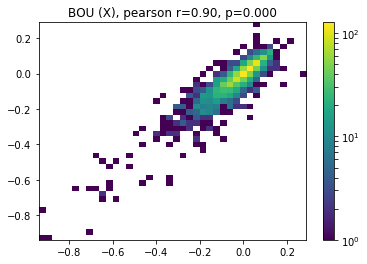

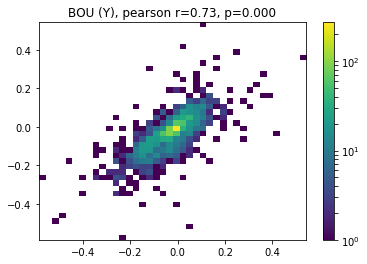

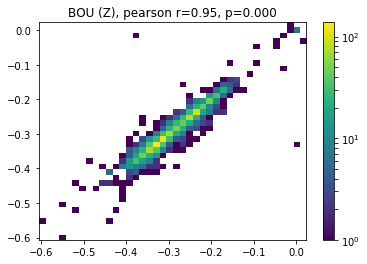

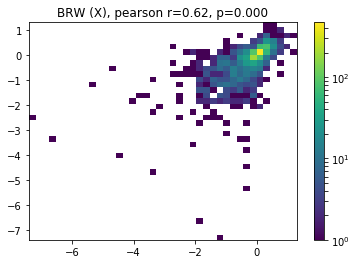

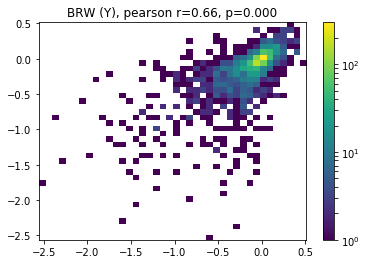

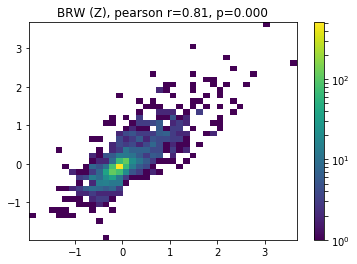

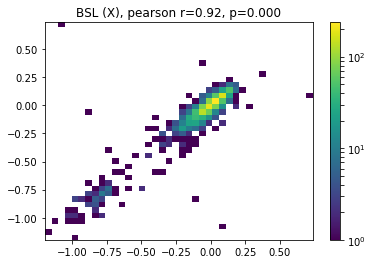

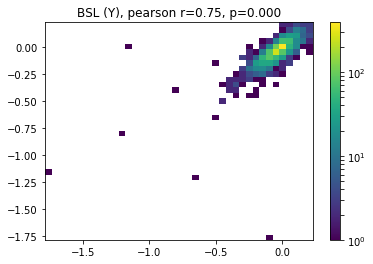

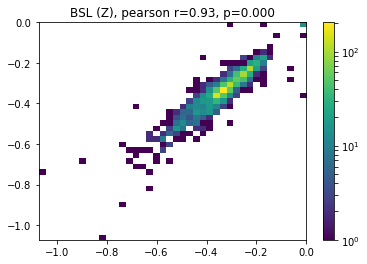

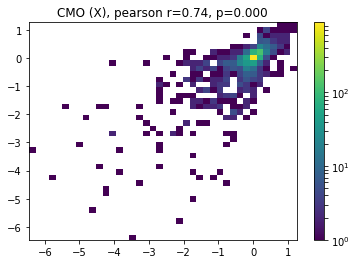

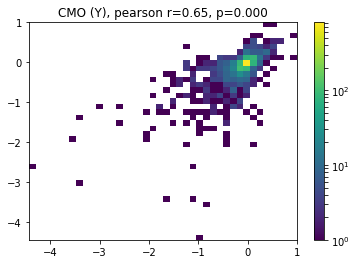

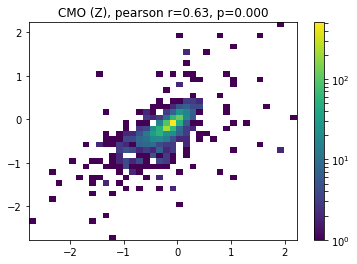

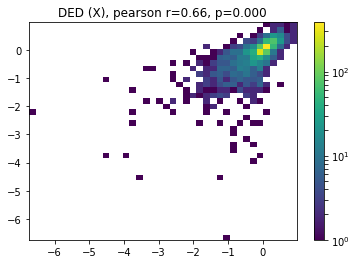

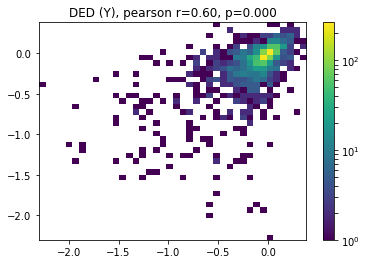

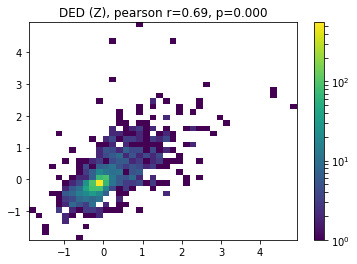

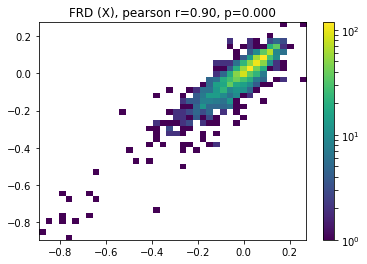

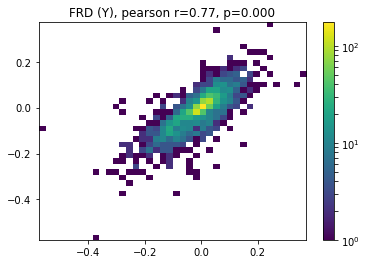

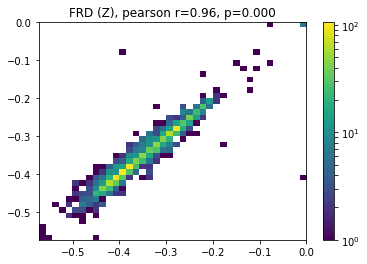

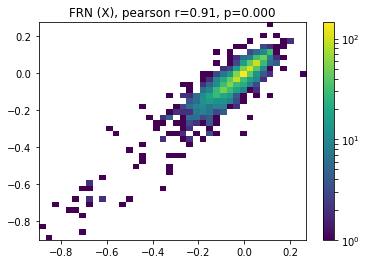

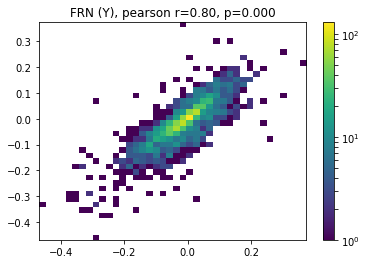

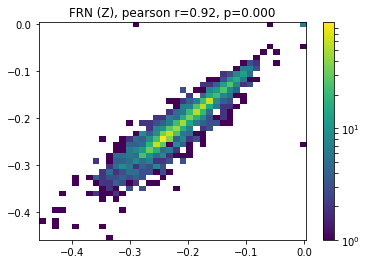

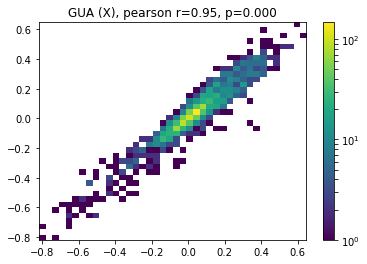

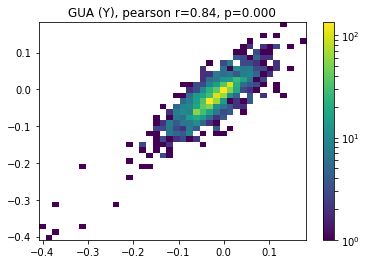

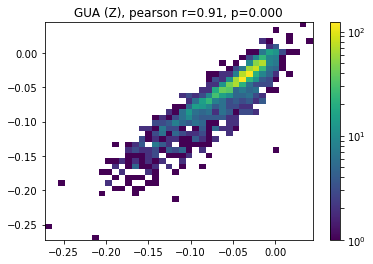

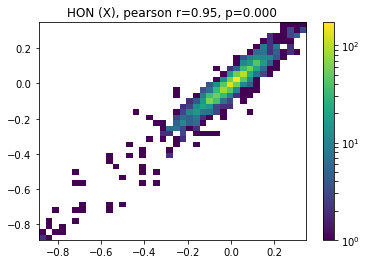

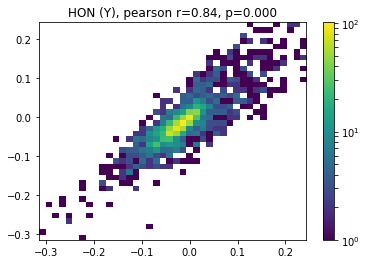

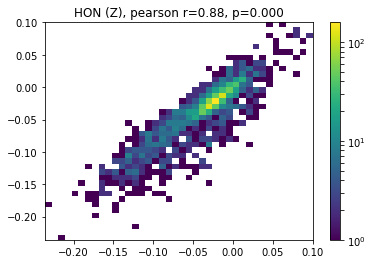

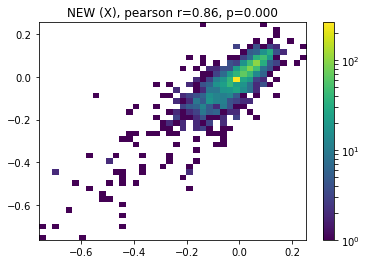

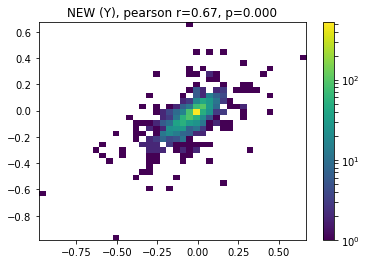

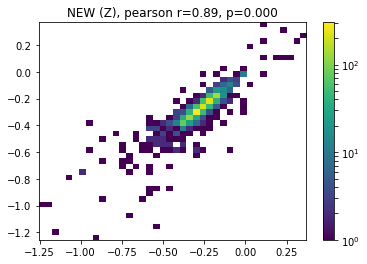

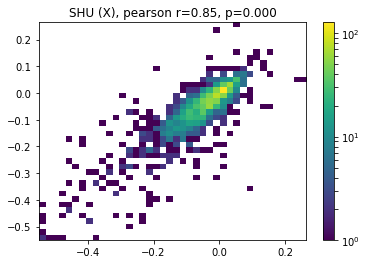

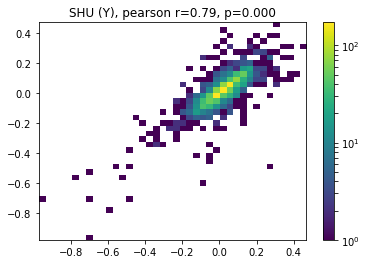

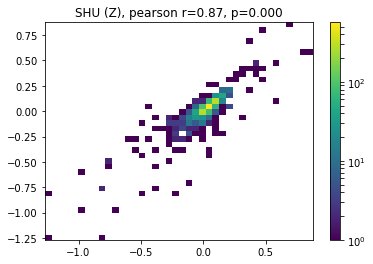

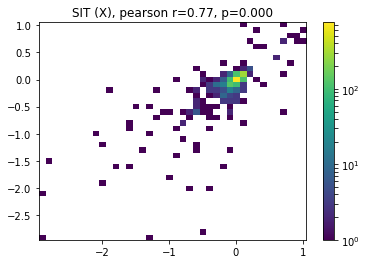

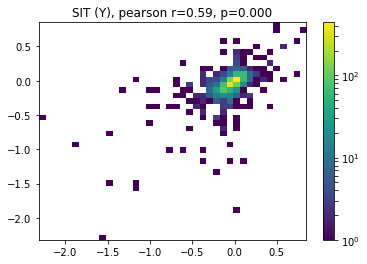

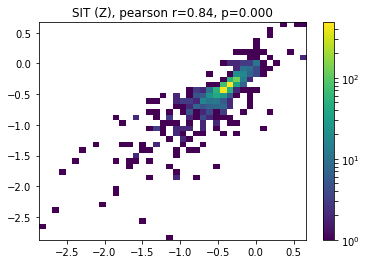

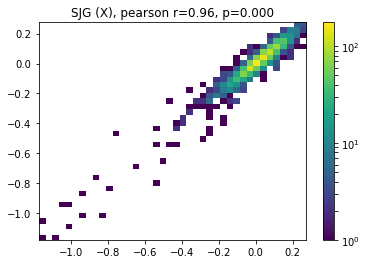

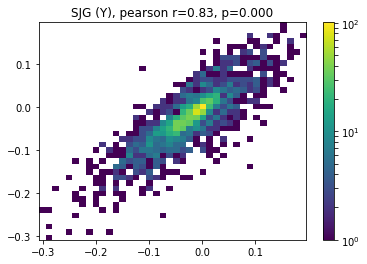

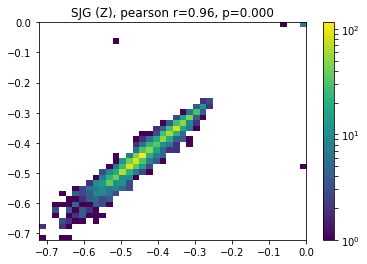

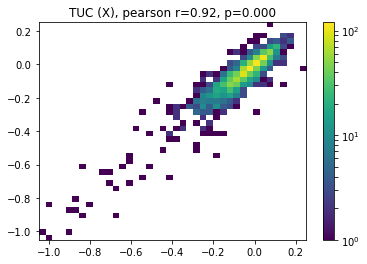

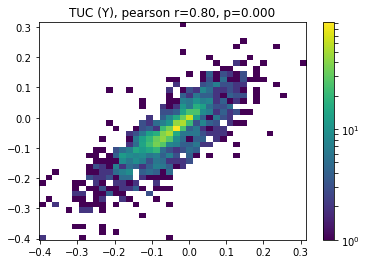

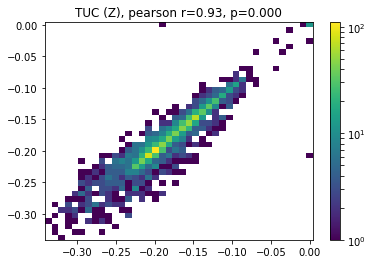

In [16]:
for c in range(inverted_test.shape[2]):
    pyplot.figure(c)
    obs = int(np.floor(c/len(CHANNELS)))
    comp = c % len(CHANNELS)

    x = inverted_test[0:-2,len(lags)-1,c]
    y = inverted_test[1:-1,len(lags)-1,c]
    pyplot.hist2d(x, y, bins=40, norm=LogNorm())
    #pyplot.axis('equal')
    #pyplot.axis([-5,5,-5,5])
    pyplot.colorbar()
    corr = pearsonr(x,y)
    pyplot.title("{0} ({1}), pearson r={2:.2f}, p={3:.3f}".format(OBSERVATORIES[obs],CHANNELS[comp],corr[0],corr[1]))
    pyplot.show()


In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()